https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/speech_commands/train.py Training Script

https://arxiv.org/pdf/1804.03209.pdf  Paper



0 = Yes
1 = No,
2 = Up,
3 = Down,
4 = Left,
5 = Right,
6 = On,
7 = Off,
8 = Stop,
9 = Go,
10 = Zero,
11 = One,
12 = Two,
13 = Three,
14 = Four,
15 = Five,
16 = Six,
17 = Seven,
18 = Eight,
19 = Nine,
20 = Bed,
21 = Bird,
22 = cat,
23 = Dog,
24 = Happy,
25 = House,
26 = Marvin,
27 = Sheila,
28 = Tree,
29 = Wow,
30 = silence,

Features from Laura

Music feature extraction in python https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d

spectral features https://musicinformationretrieval.com/spectral_features.html

spectral audio signal processing https://ccrma.stanford.edu/~jos/sasp/

crossing rate https://librosa.org/doc/main/generated/librosa.feature.zero_crossing_rate.html

https://www.sciencedirect.com/topics/engineering/zero-crossing-rate

spectral centroid https://www.sciencedirect.com/topics/engineering/spectral-centroid


spectral entropy https://www.sciencedirect.com/topics/computer-science/spectral-entropy

https://dsp.stackexchange.com/questions/23689/what-is-spectral-entropy

https://www.mathworks.com/help/signal/ref/pentropy.html

https://raphaelvallat.com/entropy/build/html/generated/entropy.spectral_entropy.html

spectral flux https://www.sciencedirect.com/topics/engineering/spectral-flux

https://www.mathworks.com/help/audio/ref/spectralflux.html

spectral roll https://musicinformationretrieval.com/spectral_features.html

https://librosa.org/doc/main/generated/librosa.feature.spectral_rolloff.html

spectral energy



In [1]:
!pip install renumics-spotlight datasets[audio]
!pip install tensorflow
!pip install numpy==1.24
%env NotebookApp.iopub_data_rate_limit=1.0e12

env: NotebookApp.iopub_data_rate_limit=1.0e12


In [2]:
import pandas as pd
import renumics.spotlight as spotlight
import datasets
import io
import numpy as np
import torchaudio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from random import randint

dataset = datasets.load_dataset("renumics/speech_commands_enriched", "v0.01")
df1 = dataset["train"].to_pandas()
df2 = dataset["validation"].to_pandas()
df3 = dataset["test"].to_pandas()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/51093 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6799 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3081 [00:00<?, ? examples/s]

In [3]:
# Function to extract a 1-second slice from silence audio
def sample_silence(audio, sample_rate):
    if len(audio) > sample_rate:  # Ensure audio is longer than 1 second
        random_offset = randint(0, len(audio) - sample_rate)
        return audio[random_offset:random_offset + sample_rate]
    return audio  # Return the original if less than 1 second

In [4]:
# Initialize lists to hold your labels and audio data
labels = []
audio_data = []

for index, row in df1.iterrows():
    # Extract label and audio bytes for each instance
    label = row['label']  # Adjust 'label' if necessary to match your DataFrame
    audio_bytes = row['full_audio']['bytes']  # Adjust 'full_audio' to match your DataFrame structure
    #print(audio_bytes)

    # Load the audio file from bytes
    audio_buffer = io.BytesIO(audio_bytes)
    a, sr = librosa.load(audio_buffer)
    if(label == 30):
      a = sample_silence(a, sr)
    # Append the label, audio data, and sample rate to their respective lists
    labels.append(label)
    audio_data.append(a)

# Create a DataFrame from the lists
dftrain = pd.DataFrame({
    'label': labels,
    'audio': audio_data,
})

# Now df contains three columns: 'label', 'audio', and 'sample_rate'
# with each row representing a different audio file
# Iterate over each row in the testing dataset DataFrame
for index, row in df2.iterrows():
    # Extract label and audio bytes for each instance
    # Adjust the column names if necessary to match your testing DataFrame
    label = row['label']  # Use the correct column name for labels
    audio_bytes = row['full_audio']['bytes']  # Adjust 'full_audio' to match your DataFrame structure

    # Load the audio file from bytes
    audio_buffer = io.BytesIO(audio_bytes)
    a, sr = librosa.load(audio_buffer)  # 'sr=None' to preserve the original sample rate
    if(label == 30):
      a = sample_silence(a, sr)
    # Append the label, audio data to their respective lists
    labels.append(label)
    audio_data.append(a)

# Create a DataFrame from the lists for the testing data
df_val = pd.DataFrame({
      'label': labels,
      'audio': audio_data,
})

# Iterate over each row in the testing dataset DataFrame
for index, row in df3.iterrows():
    # Extract label and audio bytes for each instance
    # Adjust the column names if necessary to match your testing DataFrame
    label = row['label']  # Use the correct column name for labels
    audio_bytes = row['full_audio']['bytes']  # Adjust 'full_audio' to match your DataFrame structure

    # Load the audio file from bytes
    audio_buffer = io.BytesIO(audio_bytes)
    a, sr = librosa.load(audio_buffer)  # 'sr=None' to preserve the original sample rate
    if(label == 30):
      a = sample_silence(a, sr)
    # Append the label, audio data to their respective lists
    labels.append(label)
    audio_data.append(a)

# Create a DataFrame from the lists for the testing data
df_test = pd.DataFrame({
    'label': labels,
    'audio': audio_data,
})

In [5]:
def extract_features(y, sr=16000):
    # Extracting MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512)
    mean_mfcc = np.mean(mfcc.T, axis=0)
    std_mfcc = np.std(mfcc.T, axis=0)
    delta_mfcc = np.mean(librosa.feature.delta(mfcc), axis=1)
    delta2_mfcc = np.mean(librosa.feature.delta(mfcc, order=2), axis=1)

    # Extracting Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    mean_zcr = np.mean(zcr)
    std_zcr = np.std(zcr)

    # Extracting Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=2048, hop_length=512)
    mean_chroma = np.mean(chroma, axis=1)
    std_chroma = np.std(chroma, axis=1)

    # Extracting Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)
    mean_mel = np.mean(mel_spectrogram, axis=1)
    std_mel = np.std(mel_spectrogram, axis=1)

    # Concatenating all features into one vector
    features = np.concatenate((mean_mfcc, std_mfcc, delta_mfcc, delta2_mfcc, [mean_zcr, std_zcr], mean_chroma, std_chroma, mean_mel, std_mel))
    return features

In [6]:
# Assuming extract_mfcc function is correctly implemented to return an array of shape (13,)
X_train = np.stack(dftrain['audio'].apply(lambda x: extract_features(x)).values)
y_train = dftrain['label'].values

X_val = np.stack(df_val['audio'].apply(lambda x: extract_features(x)).values)
y_val = df_val['label'].values

X_test = np.stack(df_test['audio'].apply(lambda x: extract_features(x)).values)
y_test = df_test['label'].values



/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [7]:
print("MFCC Train Shape: ", X_train.shape)
print("MFCC Train Shape: ", y_train.shape)
print("MFCC Validation Shape: ", X_val.shape)
print("MFCC Validation Shape: ", y_val.shape)
print("MFCC Testing Shape: ", X_test.shape)
print("MFCC Testing Shape: ", y_test.shape)

MFCC Train Shape:  (51093, 362)
MFCC Train Shape:  (51093,)
MFCC Validation Shape:  (57892, 362)
MFCC Validation Shape:  (57892,)
MFCC Testing Shape:  (60973, 362)
MFCC Testing Shape:  (60973,)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

def build_mlp_model(input_shape, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_dim=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Assuming you have the following setup
num_features = 362  # Number of input features
num_classes = len(np.unique(y_train))  # Adjust based on your number of classes

# Building the model
model = build_mlp_model(input_shape=num_features, num_classes=num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               185856    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Example: Define input_shape and num_classes according to your dataset
input_shape = (None, 362)  # None can be the sequence length which can vary
num_classes = 31
# Assume you have x_train, y_train, x_val, y_val properly prepared and shaped
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64, #Batch size and learning rate are inverse If you raise batch size and lower learning rate
    validation_data=(X_val, y_val)
)

Epoch 1/50
799/799 [==============================] - 17s 19ms/step - loss: 3.0002 - accuracy: 0.1788 - val_loss: 2.2136 - val_accuracy: 0.3663
Epoch 2/50
799/799 [==============================] - 13s 16ms/step - loss: 2.2587 - accuracy: 0.3247 - val_loss: 1.9133 - val_accuracy: 0.4404
Epoch 3/50
799/799 [==============================] - 12s 15ms/step - loss: 2.0312 - accuracy: 0.3846 - val_loss: 1.7673 - val_accuracy: 0.4786
Epoch 4/50
799/799 [==============================] - 12s 15ms/step - loss: 1.9042 - accuracy: 0.4199 - val_loss: 1.6561 - val_accuracy: 0.5101
Epoch 5/50
799/799 [==============================] - 14s 18ms/step - loss: 1.8039 - accuracy: 0.4498 - val_loss: 1.5954 - val_accuracy: 0.5200
Epoch 6/50
799/799 [==============================] - 12s 15ms/step - loss: 1.7428 - accuracy: 0.4709 - val_loss: 1.5129 - val_accuracy: 0.5483
Epoch 7/50
799/799 [==============================] - 12s 15ms/step - loss: 1.6871 - accuracy: 0.4835 - val_loss: 1.4498 - val_accuracy:

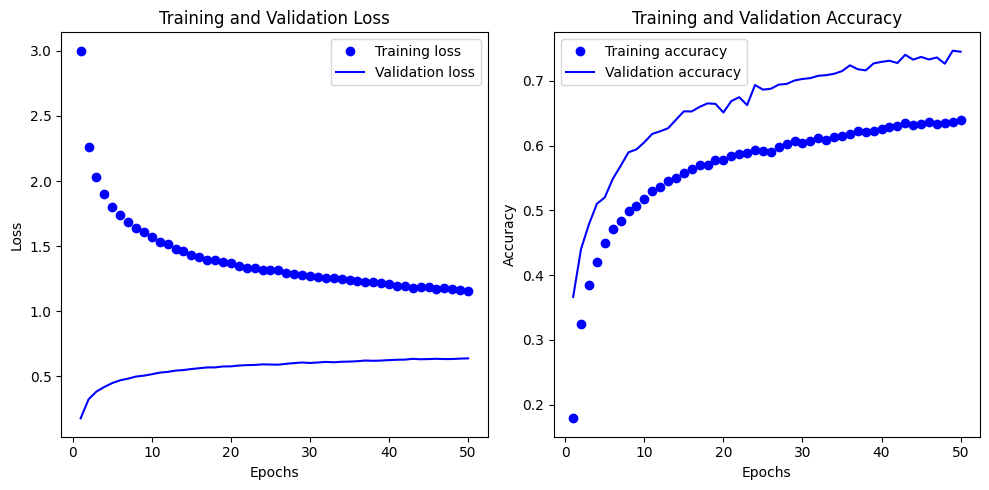

In [10]:
history_dict = history.history

# Extract values from the history object
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']  # Change 'accuracy' to 'acc' if you encounter a key error
val_acc_values = history_dict['val_accuracy']  # Change 'val_accuracy' to 'val_acc' if you encounter a key error

epochs = range(1, len(loss_values) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, acc_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
val_loss_values
# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_classes, average='macro')
recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

1906/1906 [==============================] - 5s 3ms/step
Precision: 0.7511
Recall: 0.7265
F1 Score: 0.7312


Confusion Matrix:
 [[1913    1    4   11   33   40    0    5    3    6   14   20    7   11
     9    0  125   71   45    3    8    1   17    0    9    9    2    4
     5    0    1]
 [   0 1219   23  141   46   23   23   11    4  205    8  326   17    3
    16   12    1   16    3   81   25    8    2   58    3    8   41    1
     2   49    0]
 [   3   12 1794   18   61   10   26   65   36   48    0   70    3    0
     2   50    2    6    6    7    7    3    8  100    7    3    8    2
     0   17    1]
 [   2   76   15 1577   16   34   32    4    3   50    6   87    2    0
     1   34    6   28    2  130   29    6   28   46    2    0   88    3
     3   49    0]
 [  26   60   70   50 1579   74    5    3   37   45    5   56   15    4
     2   26   11  110   12   18   39    7   25   18   12   19    7    7
     4    7    0]
 [  27   21   14  113   46 1666    3    2   16   24   46   41    9   19
    14   33    6   34    4   37   10   27   22    2   46   19   38   12
     7    9    0]
 [   3   

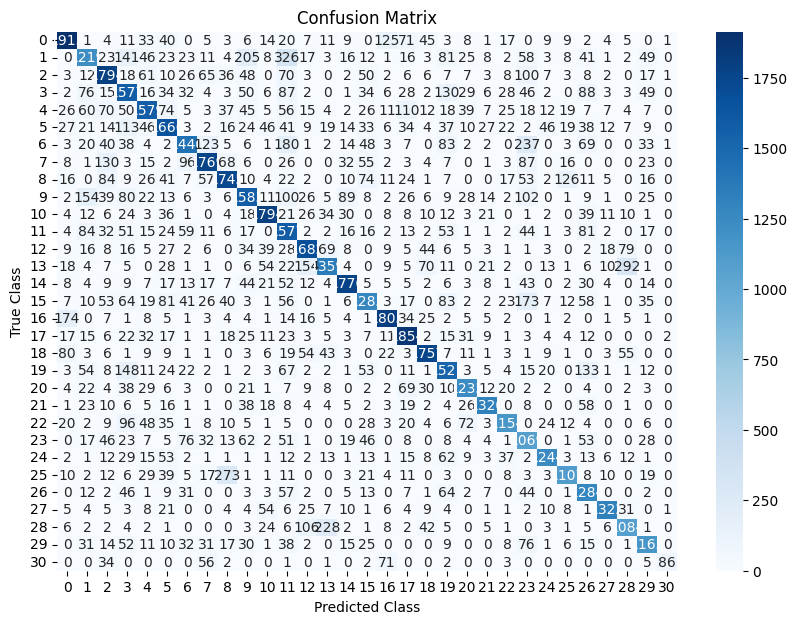

The class that was mispredicted the most is Class 1 with 1156 errors.
The class that was predicted correctly the most is Class 0 with 1913 correct predictions.
Overall accuracy of the model is 0.7342.


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred_classes are defined from your model's output

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

# Find the class with the most misclassifications
errors = np.sum(cm, axis=1) - np.diagonal(cm)  # Sum of each row minus the diagonal element
most_misclassified_class = np.argmax(errors)

# Find the class with the most correct predictions
most_correctly_guessed_class = np.argmax(np.diagonal(cm))

# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

print(f"The class that was mispredicted the most is Class {most_misclassified_class} with {errors[most_misclassified_class]} errors.")
print(f"The class that was predicted correctly the most is Class {most_correctly_guessed_class} with {cm[most_correctly_guessed_class, most_correctly_guessed_class]} correct predictions.")
print(f"Overall accuracy of the model is {accuracy:.4f}.")
